#Grid vs. Randomized Searches for Hyperparameter Optimization
###Author: Andrew Mehrmann
###ASTR 596

In [229]:
%matplotlib inline

In [230]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from collections import Counter
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier

####Load in and Inspect the Data


In [237]:
print(dgts.DESCR)

 Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is 

In [231]:
dgts = datasets.load_digits()
X = dgts.data
y = dgts.target

In [232]:
Counter(y)

Counter({3: 183, 1: 182, 5: 182, 4: 181, 6: 181, 9: 180, 7: 179, 0: 178, 2: 177, 8: 174})

In [238]:
X.shape

(1797, 64)

####Define the classifier

In [239]:
forest = RandomForestClassifier(n_estimators = 100)

##Grid (Exhaustive) Search

In [240]:
feat_range = np.arange(1,X.shape[1],10)
depth_range = np.arange(1,51,10)
boot_range = [True, False]

params = {'max_features':feat_range,
         'max_depth':depth_range,
         'bootstrap':boot_range}

n_combos = len(feat_range) + len(depth_range) + len(boot_range)

print('the exhaustive search will examine {0} candidates'.format(n_combos))

the exhaustive search will examine 14 candidates


In [241]:
grid = GridSearchCV(forest, params, cv = 5, n_jobs=-1, scoring='accuracy')

start = datetime.datetime.now()

grid+search = grid.fit(X,y)

elapsed = datetime.datetime.now() - start
print('{0} seconds elapsed during exhaustive search'.format(elapsed.seconds))

df = pd.DataFrame(grid.grid_scores_)
df.columns = ['params','mean_score','scores']
df['sd'] = df.scores.apply(np.std)
df = df.drop('scores',axis=1)
df_sorted = df.sort('mean_score', ascending=False)
df_sorted.head(10)

115 seconds elapsed during exhaustive search


,params,mean_score,sd
57,"{u'max_features': 11, u'bootstrap': False, u'm...",0.942682,0.024037
50,"{u'max_features': 11, u'bootstrap': False, u'm...",0.942126,0.026124
43,"{u'max_features': 11, u'bootstrap': False, u'm...",0.941569,0.017824
63,"{u'max_features': 1, u'bootstrap': False, u'ma...",0.941569,0.024184
28,"{u'max_features': 1, u'bootstrap': True, u'max...",0.939900,0.021704
64,"{u'max_features': 11, u'bootstrap': False, u'm...",0.939900,0.020716
49,"{u'max_features': 1, u'bootstrap': False, u'ma...",0.938787,0.018358
56,"{u'max_features': 1, u'bootstrap': False, u'ma...",0.938787,0.024643
58,"{u'max_features': 21, u'bootstrap': False, u'm...",0.938230,0.025025
15,"{u'max_features': 11, u'bootstrap': True, u'ma...",0.937674,0.024054


##Randomized Search

In [257]:
n_iter = 5

feat_range = sp_randint(1,X.shape[1])
depth_range = sp_randint(1,51)
boot_range = [True, False]


params = {'max_features':feat_range,
         'max_depth':depth_range,
         'bootstrap':boot_range}

print('the randomized search will examine {0} candidates'.format(n_iter))

the randomized search will examine 5 candidates


In [258]:
rand = RandomizedSearchCV(forest, params, cv=5, n_jobs=-1, n_iter=n_iter, scoring='accuracy')

start = datetime.datetime.now()

random_search = rand.fit(X,y)

elapsed = datetime.datetime.now() - start
print('{0} seconds elapsed during randomized search'.format(elapsed.seconds))

df_rand = pd.DataFrame(rand.grid_scores_)
df_rand.columns = ['params','mean_score','scores']
df_rand['sd'] = df_rand.scores.apply(np.std)
df_rand = df_rand.drop('scores',axis=1)
df_rand_sorted = df_rand.sort('mean_score', ascending=False)
df_rand_sorted.head(10)


9 seconds elapsed during randomized search


,params,mean_score,sd
1,"{u'max_features': 9, u'bootstrap': True, u'max...",0.933222,0.023536
4,"{u'max_features': 33, u'bootstrap': True, u'ma...",0.924318,0.025858
2,"{u'max_features': 23, u'bootstrap': True, u'ma...",0.919866,0.032042
0,"{u'max_features': 49, u'bootstrap': True, u'ma...",0.913189,0.025895
3,"{u'max_features': 44, u'bootstrap': False, u'm...",0.909850,0.024510


##Pipelines

In [244]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from scipy.stats import uniform

In [245]:
pca = PCA()
pipeline = Pipeline([("components", pca), ("rfc", forest)])

feat_range = uniform(0,1)
depth_range = sp_randint(1,51)
boot_range = [True, False]
pc_range = sp_randint(1,X.shape[1])

params = {'rfc__max_features':feat_range,
         'rfc__max_depth':depth_range,
         'rfc__bootstrap':boot_range,
         'components__n_components':pc_range}


In [246]:
search = RandomizedSearchCV(pipeline, params, cv=5, n_jobs=-1, n_iter=20, scoring='accuracy')

start = datetime.datetime.now()

pipe_search = search.fit(X,y)

elapsed = datetime.datetime.now() - start
print('{0} seconds elapsed during randomized search'.format(elapsed.seconds))

df_pipe = pd.DataFrame(search.grid_scores_)
df_pipe.columns = ['params','mean_score','scores']
df_pipe['sd'] = df_pipe.scores.apply(np.std)
df_pipe = df_pipe.drop('scores',axis=1)
df_pipe_sorted = df_pipe.sort('mean_score', ascending=False)
df_pipe_sorted.head(10)


54 seconds elapsed during randomized search


,params,mean_score,sd
0,"{u'rfc__max_depth': 22, u'rfc__bootstrap': Fal...",0.944352,0.013315
8,"{u'rfc__max_depth': 23, u'rfc__bootstrap': Tru...",0.937674,0.016903
18,"{u'rfc__max_depth': 24, u'rfc__bootstrap': Fal...",0.936004,0.026725
1,"{u'rfc__max_depth': 20, u'rfc__bootstrap': Fal...",0.935448,0.022380
5,"{u'rfc__max_depth': 9, u'rfc__bootstrap': Fals...",0.932666,0.018817
13,"{u'rfc__max_depth': 36, u'rfc__bootstrap': Fal...",0.929883,0.029064
11,"{u'rfc__max_depth': 47, u'rfc__bootstrap': Fal...",0.921536,0.019499
4,"{u'rfc__max_depth': 16, u'rfc__bootstrap': Fal...",0.918753,0.027245
16,"{u'rfc__max_depth': 14, u'rfc__bootstrap': Fal...",0.915971,0.028186
17,"{u'rfc__max_depth': 9, u'rfc__bootstrap': Fals...",0.915415,0.018995


##Model Assessment

####Select and fit a model on training data

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [262]:
forest = random_search.best_estimator_
y_pred = forest.fit(X_train, y_train).predict(X_test)

####Confusion Matrices and Classification Reports

In [297]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [272]:
df_confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

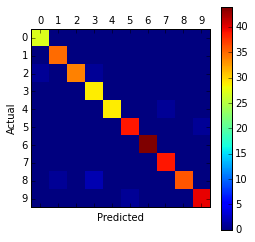

In [296]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion) # imshow
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
plot_confusion_matrix(df_confusion)

In [299]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.96      1.00      0.98        27
          1       0.97      1.00      0.99        35
          2       1.00      0.94      0.97        36
          3       0.91      1.00      0.95        29
          4       1.00      0.97      0.98        30
          5       0.97      0.97      0.97        40
          6       1.00      1.00      1.00        44
          7       0.97      1.00      0.99        39
          8       1.00      0.92      0.96        39
          9       0.98      0.98      0.98        41

avg / total       0.98      0.98      0.98       360



####Performance Metrics

###References

* http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf
* http://scikit-learn.org/stable/auto_examples/model_selection/randomized_search.html